# Lorenz attractor

In 1963, Edward Lorenz developed a simplified mathematical model for atmospheric convection.The model is a system of three ordinary differential equations now known as the Lorenz equations:

\begin{eqnarray}
    \dot{x} &=& \sigma(y-x)\\
    \dot{y} &=& x(\rho-z)-y\\
    \dot{z} &=& xy-\beta z
\end{eqnarray}

Here $x$, $y$, and $z$ make up the system state, $t$ is time, and $\sigma$, $\beta$, $\rho$ are the system parameters. The Lorenz equations also arise in simplified models for lasers, dynamos, thermosyphons, brushless DC motors, electric circuits, chemical reactions and forward osmosis.

From a technical standpoint, the Lorenz system is nonlinear, non-periodic, three-dimensional and deterministic. The Lorenz equations have been the subject of hundreds of research articles, and at least one book-length study.

Lorenz used the values $\sigma=10.0$, $\beta=8.0/3.0$, $\rho=28.0$. The system exhibits chaotic behavior for these (and nearby) values.

#### Source : https://en.wikipedia.org/wiki/Lorenz_system

--------------------------------

# PuCUDA code

In [31]:
import pycuda.autoinit
from pycuda import gpuarray, compiler
import numpy as np
import matplotlib.pyplot as plt

In [32]:
kernel_code_template = """

/***********************************************************************************/
// Function definition of Lorenz attractor

__device__ void rhs(float x[], float &fx, float &t, float &a, float &b, float &c)
{
    const uint tx=threadIdx.x;
    
    if(tx==0)   fx = a*(x[1]-x[0]);
    if(tx==1)   fx = (c-x[2])*x[0]-x[1];
    if(tx==2)   fx = x[0]*x[1]-b*x[2];
    
    __syncthreads();
}

/***********************************************************************************/
// 4th order Runge-Kutta Method of ODE integration

__device__ void rk4(float x[], float &t, float &dt, float &a, float &b, float &c)
{
    float k1, k2, k3, k4, fx, t1;
    __shared__ float tmp[%(n)s];
    const uint tx = threadIdx.x;
    
    rhs(x,   fx, t,  a, b, c);     k1 = dt*fx;    tmp[tx] = x[tx] + k1/2.0;     t1=t+dt/2.0;
    rhs(tmp, fx, t1, a, b, c);     k2 = dt*fx;    tmp[tx] = x[tx] + k2/2.0; ;   t1=t+dt/2.0;
    rhs(tmp, fx, t1, a, b, c);     k3 = dt*fx;    tmp[tx] = x[tx] + k3; ;       t1=t+dt;
    rhs(tmp, fx, t1, a, b, c);     k4 = dt*fx;
    
    x[tx] = x[tx] + (k1+2.0*(k2+k3)+k4)/6.0;
    __syncthreads();
}

/***********************************************************************************/
// Function for calculating time series

__global__ void dynamics(float *xt, float *xi)
{

    const uint tx=threadIdx.x, bd=blockDim.x;
    float a=%(a)s, b=%(b)s, c=%(c)s;
    float dt=%(dt)s;
    const uint n=%(n)s, nt=%(nt)s;
    __shared__ float x[n];
    
    x[tx] = xi[tx];
    
    float t=0.0;
    
    for(int i=0;i<100*nt;i++)
    {
        t=t+dt;
        rk4(x,t,dt,a,b,c);
    }
    
    t = 0.0;
    
    for(int i=0;i<nt;i++)
    {
        t=t+dt;
        rk4(x,t,dt,a,b,c);
        xt[i*(bd+1)+0]=t;
        for(int j=1;j<n+1;j++) xt[i*(bd+1)+j]=x[j-1];
    }

}

/***********************************************************************************/

"""

In [33]:
# n  : Dimension of the system
# T  : Total time of evolution
# dt : Time step
n=3
T=30.0
dt=0.005

# Allocation on GPU

# Initial conditions in the range [-10.0,10.0)
xi = gpuarray.to_gpu(np.random.uniform(-10.0,10.0,n).astype(np.float32))

# Array to store time series data
# col1:time, col2:x, col3:y, col4:z
xt = gpuarray.empty(np.array([int(T/dt),n+1]), np.float32)

In [34]:
# Compilation of kernel code and getting function
kernel_code = kernel_code_template % {'a':10.0, 'b':8.0/3.0, 'c':28.0, 'n':n, 'dt':dt, 'nt':int(T/dt)}
mod = compiler.SourceModule(kernel_code)
dynamics = mod.get_function("dynamics")

In [35]:
# Running the function on GPU defined in kernel
dynamics(xt,xi,block=(n,1,1))

# Copy data from GPU to CPU
xt_cpu=xt.get()

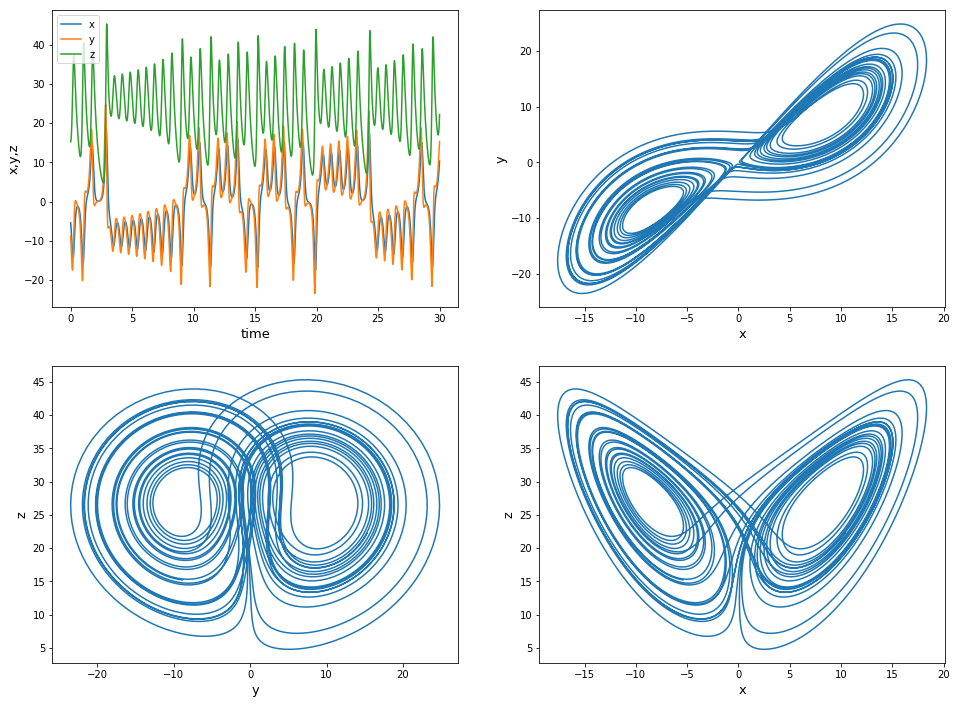

In [36]:
# Code for generating plots

plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.xlabel('time',fontsize=13)
plt.ylabel('x,y,z',fontsize=13)
plt.plot(xt_cpu[:,0],xt_cpu[:,1],label='x')
plt.plot(xt_cpu[:,0],xt_cpu[:,2],label='y')
plt.plot(xt_cpu[:,0],xt_cpu[:,3],label='z')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel('x',fontsize=13)
plt.ylabel('y',fontsize=13)
plt.plot(xt_cpu[:,1],xt_cpu[:,2])

plt.subplot(2,2,3)
plt.xlabel('y',fontsize=13)
plt.ylabel('z',fontsize=13)
plt.plot(xt_cpu[:,2],xt_cpu[:,3])

plt.subplot(2,2,4)
plt.xlabel('x',fontsize=13)
plt.ylabel('z',fontsize=13)
plt.plot(xt_cpu[:,1],xt_cpu[:,3])

plt.show()